# Research Experiments on the effect of parent Selection on Generalization for symbolic Regression in GP

* Masterseminar: SoSe 2022
* JGU Mainz
* FB 03 Recht-und Wirtschaftswissenschaften
* Lehrstuhl für Wirtschaftsinformatik und BWL

## Dependencies

In [3]:
import numpy as np
import pandas as pd
import operator

from deap import gp, tools, creator, base, algorithms
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict
import math
from random import randint


## Energy efficiency Data Set

Source: https://archive.ics.uci.edu/ml/datasets/energy+efficiency

In [4]:
# (re-)download file to ./data

# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx -P ./data

In [5]:
D_PATH = "data/ENB2012_data.xlsx"

# TODO: research optimal splitsize!
TRAINING_D_SPLITSIZE = 0.5

def get_dataSets(datapath: str, train_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Read (excel) dataset at <datapath> and return two randomly split DFs for training/testing"""
    df = pd.read_excel(datapath)
    return train_test_split(df, train_size=train_size, test_size=(1-train_size))    

trainDF, testDF = get_dataSets(D_PATH, TRAINING_D_SPLITSIZE)

In [6]:
trainDF.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
734,0.82,612.5,318.5,147.0,7.0,4,0.4,5,29.06,33.84
25,0.74,686.0,245.0,220.5,3.5,3,0.0,0,6.05,11.19
180,0.66,759.5,318.5,220.5,3.5,2,0.1,3,11.59,13.46
730,0.86,588.0,294.0,147.0,7.0,4,0.4,5,31.12,36.26
651,0.74,686.0,245.0,220.5,3.5,5,0.4,3,13.78,16.60


In [7]:
# FIXME: Remove after testing

# load a single test case
for _, elem in trainDF.iterrows():
    test_case = elem
    break

test_case_arr = test_case.values

print(
    type(test_case_arr),
    "\n",
    test_case_arr
)

<class 'numpy.ndarray'> 
 [8.200e-01 6.125e+02 3.185e+02 1.470e+02 7.000e+00 4.000e+00 4.000e-01
 5.000e+00 2.906e+01 3.384e+01]


## Data Visualization

In [8]:
from matplotlib import pyplot as plt
import networkx as nx
import pygraphviz as pgv

%matplotlib inline

def plot_exprTree(expr_tree, title:str) -> None:
    """plots an expression tree"""
    nodes, edges, labels = gp.graph(expr_tree)

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog="dot")

    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)

    plt.title(title)
    plt.show()

## GP System Setup

### Primitive set

In [9]:
UVS = {
    "ARG0" : "X1",
    "ARG1" : "X2",
    "ARG2" : "X3",
    "ARG3" : "X4",
    "ARG4" : "X5",
    "ARG5" : "X6",
    "ARG6" : "X7",
    "ARG7" : "X8",
}

# register the Primitive Set
pset = gp.PrimitiveSet("MAIN", arity=len(UVS))

# rename ARGS to match the dataset
for arg, des in UVS.items():
    pset.renameArguments(arg=des)


In [10]:
# adding functions

def saveDiv(lhs, rhs) -> float:
    """
    GP-save implementation of Division
    [@poli08:fieldguide, p.22]
    """
    if rhs == 0:
        return 1
    return lhs / rhs


operators = (
    (operator.add, 2),
    (operator.sub, 2),
    (operator.mul, 2),
    (saveDiv, 2),
    (math.sin, 1),
    (math.cos, 1),
    # FIXME: (math.exp, 1),
    # FIXME: (math.log, 1),
    (operator.neg, 1)
)

for (func, arity) in operators:
    pset.addPrimitive(func, arity)

pset.addEphemeralConstant("rand1", lambda: randint(-1,1))

### Custom Types

In [11]:
# min fitness object

# objective: minimize MAD for y1

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# TODO add y2? Do multiobjective symreg?

In [12]:
# individuals program
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

## Algorithmic specifications

In [13]:
# TODO: research alternatives

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [14]:
# fitness function for single fitness case:

def evaluate_single_case_y1_symReg(
    individual:creator.Individual,
    case:pd.core.series.Series
    ) -> tuple[float]:
    """
    Evaluates an individual program for a single fitness case (=row of pd.dataframe), computes and returns the absolute error for prediction and outcome for y1 and model prediction (returns an iterable for fitness_min compatability)
    """

    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    
    # compute individual with case variables
    y1_prediction = func(*case[0:8:].values)
    # optimal value:
    y1_value = case[8:9:].values[0]
    # compute absolute difference and return as fitness
    abs_err = abs(y1_prediction - y1_value)
    return (abs_err, )

In [15]:
# GP system setup

# FIXME: this limits evolution to a single test case that was drawn from trainDF!
toolbox.register("evaluate", evaluate_single_case_y1_symReg, case=test_case)

# registration:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# decoration:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

## Statistics

In [16]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [17]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                                  halloffame=hof, verbose=True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max   	min 	nevals	std    	avg    	gen	max	min	nevals	std    
0  	300   	4733.08	0  	780354	5.94	300   	48867.5	3.48333	0  	7  	2  	300   	1.45936
1  	156   	65.9407	1  	4002.84	5.54	156   	280.552	3.47   	1  	9  	1  	156   	1.38652
2  	157   	146.545	2  	27342.3	1.06	157   	1587.77	3.39   	2  	9  	1  	157   	1.30047
3  	146   	61.5103	3  	2200.84	0.618924	146   	204.772	3.5    	3  	10 	1  	146   	1.27671
4  	166   	44.9846	4  	3155.94	0.04    	166   	220.76 	3.40333	4  	9  	1  	166   	1.16361
5  	164   	31.8186	5  	3033.44	0.648894	164   	184.541	3.41333	5  	9  	1  	164   	1.22031
6  	151   	79.6209	6  	3091.56	0.416802	151   	399.781	3.34   	6  	9  	1  	151   	1.21288
7  	151   	46.4014	7  	3033.44	0.416802	151   	279.211	3.28   	7  	9  	1  	151   	0.

mul(add(ARG7, cos(add(ARG7, cos(sin(saveDiv(mul(sin(ARG4), sub(ARG4, sin(ARG5))), ARG7)))))), ARG7)


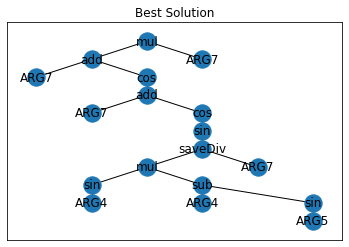

In [18]:
for elite in hof:
    print (elite)
    plot_exprTree(elite, "Best Solution")